In [1]:
import declust as dc
import scanpy as sc

Loading Data

In [2]:
sc_adata = sc.read_h5ad('data/sc_adata.h5ad')
st_adata = sc.read_h5ad('data/st_adata.h5ad')
st_adata.var_names_make_unique()
sc_adata.var_names_make_unique()

Data Preprocessing

In [3]:
st_highly_variable_genes = dc.preprocessing.select_highly_variable_genes(st_adata, n_top_genes=5000)
# sc_highly_variable_genes = dc.preprocessing.select_highly_variable_genes(sc_adata, n_top_genes=5000)

In [4]:
high_variable_common_genes = set(st_highly_variable_genes).intersection(set(sc_adata.var_names))
sc_adata_high_variable_overlapped = sc_adata[:, sc_adata.var_names.isin(high_variable_common_genes)].copy()

sc_labels = dc.preprocessing.extract_labels_from_scdata(sc_adata_high_variable_overlapped, celltype_col='celltype_major', sample_col='Patient')

sc_adata_high_variable_overlapped.to_df().to_csv('data/sc_adata_high_variable_overlapped.csv')
sc_labels.to_csv('data/sc_labels.csv')

Marker gene selection

In [5]:
sc_marker_gene = dc.marker_selection.generate_marker_genes('data/sc_adata_high_variable_overlapped.csv', 'data/sc_labels.csv', 'results/marker_genes.csv')

R[write to console]: 
载入程辑包：‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Normalization

In [7]:
sc.pp.normalize_total(st_adata, target_sum=1e4)
sc.pp.log1p(st_adata)
st_highly_variable_genes_df = st_adata[:, st_adata.to_df().var().nlargest(500).index].to_df()
coords = st_adata.obs[['array_row', 'array_col']].rename(columns={'array_row': 'x', 'array_col': 'y'}).copy()

sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)

sc_adata_marker_h5ad = sc_adata[:, sc_adata.var_names.isin(sc_marker_gene.index)].copy()

Clustering

Running Hierarchical Clustering...


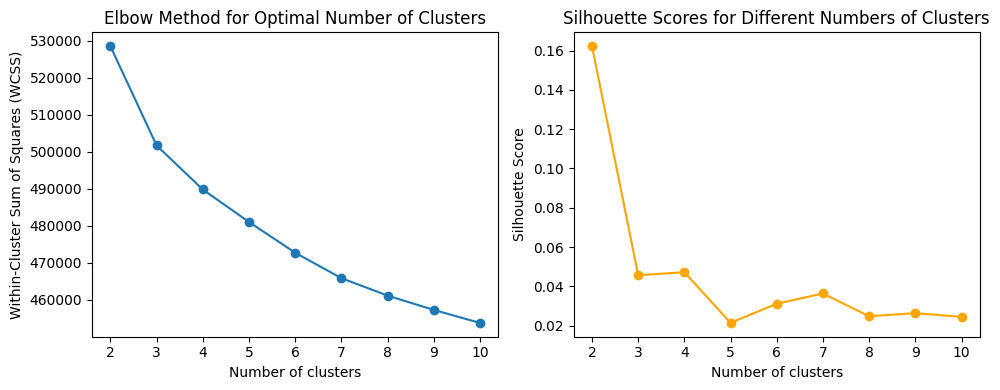

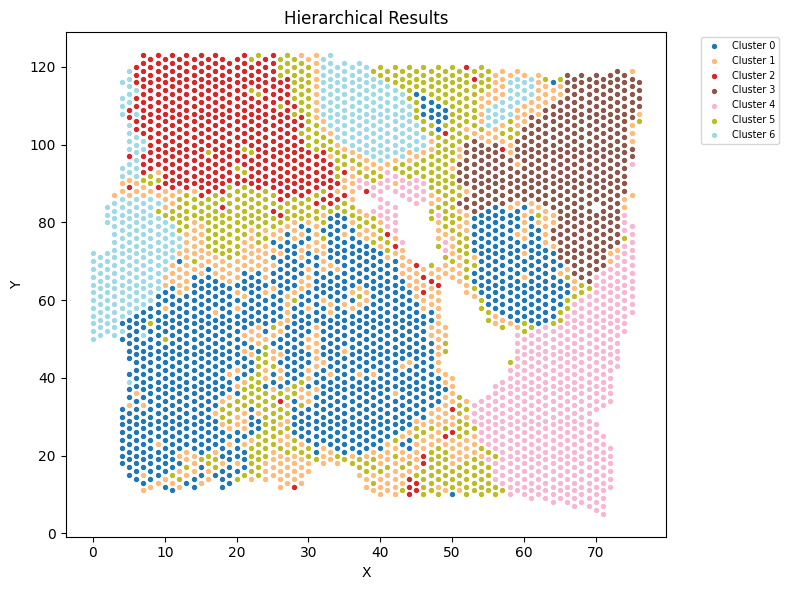

In [8]:
hierarchical_results = dc.hierarchical.clustering(st_highly_variable_genes_df, coords)

Running DBSCAN clustering...


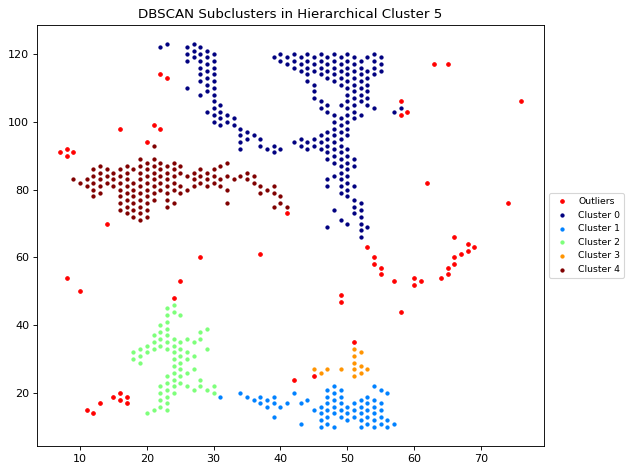

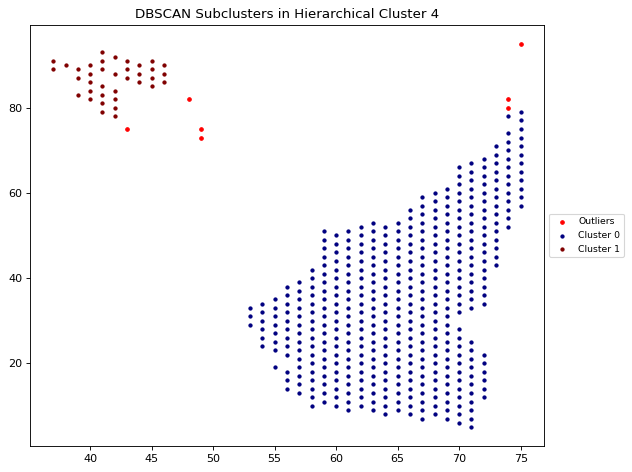

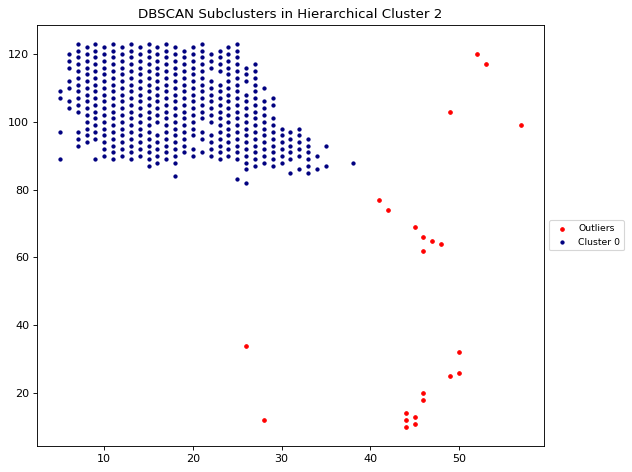

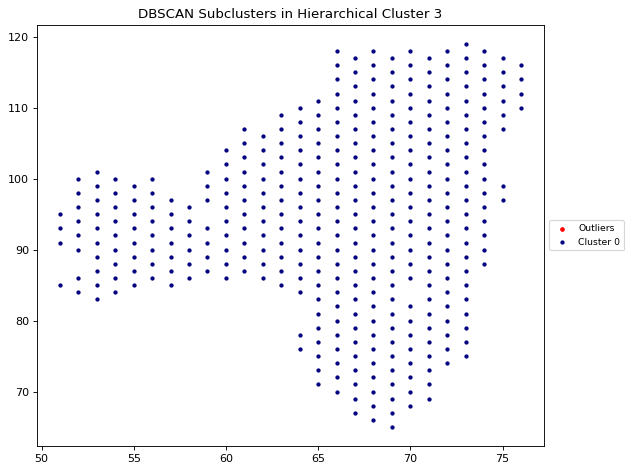

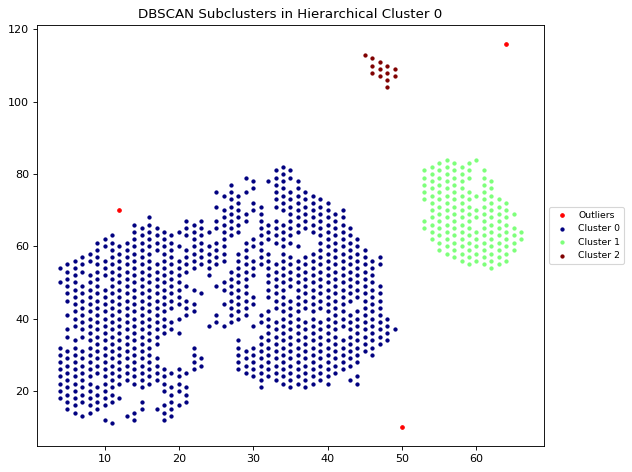

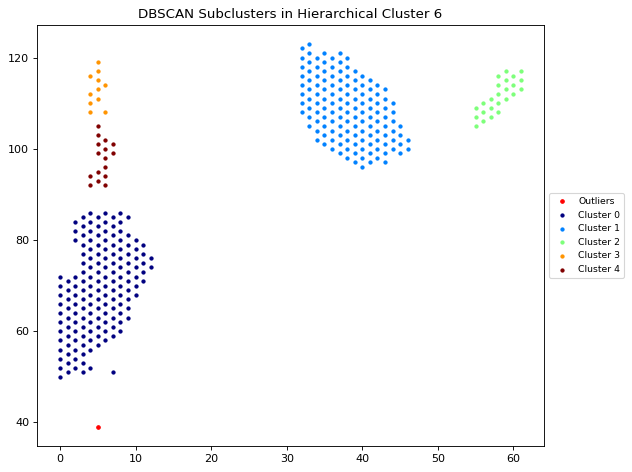

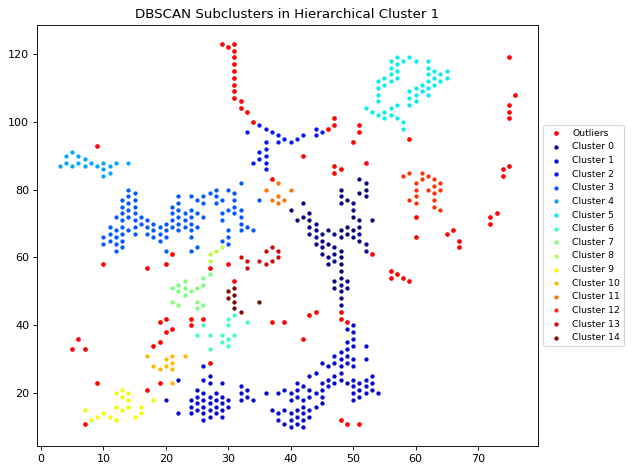

In [9]:
dbscan_centers_df = dc.dbscan.clustering(hierarchical_results, coords, visualize=True)

Running Seeded Region Growing...


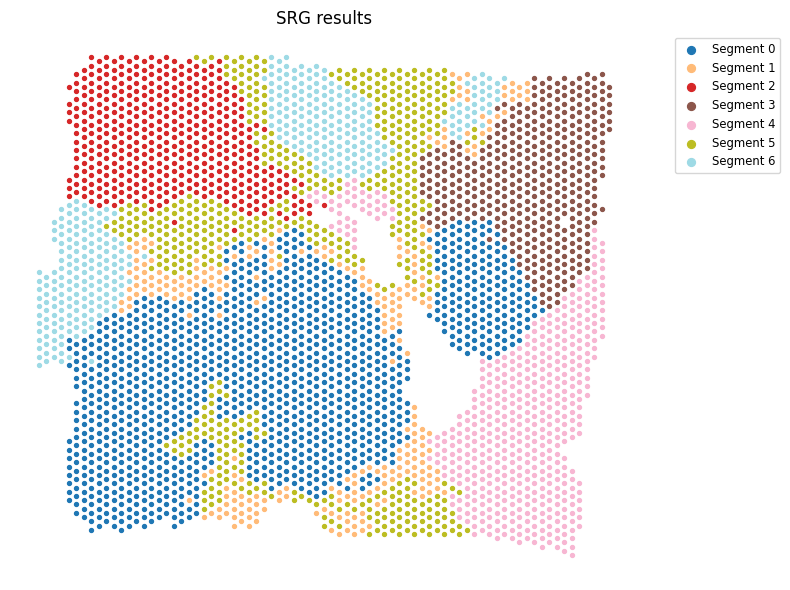

In [10]:
label_df = dc.srg.clustering(dbscan_centers_df, coords, st_highly_variable_genes_df)

Deconvolution

In [11]:
dc.deconvolution.generate_pseudo_bulk(st_adata, label_df, save_csv=True, output_path="results/pseudo_bulk.csv")

Pseudo-bulk expression data saved to: results/pseudo_bulk.csv


,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,0.0,0.0,0.0,15.602648,0.0,0.0,0.000000,0.0,2.549867,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,148.081131,17.198906
1,0.0,0.0,0.0,0.901643,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,39.786964,3.447191
2,0.0,0.0,0.0,4.188326,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,27.256210,1.369070
3,0.0,0.0,0.0,5.926352,0.0,0.0,0.000000,0.0,1.388978,0.0,...,0.0,0.0,0.295024,0.0,0.0,0.0,0.0,0.0,40.168560,3.071301
4,0.0,0.0,0.0,5.145960,0.0,0.0,0.306164,0.0,0.485095,0.0,...,0.0,0.0,0.204035,0.0,0.0,0.0,0.0,0.0,47.859779,4.727655
5,0.0,0.0,0.0,3.209607,0.0,0.0,0.000000,0.0,0.839228,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,53.652023,6.048203
6,0.0,0.0,0.0,4.035772,0.0,0.0,0.000000,0.0,0.159949,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,38.953152,3.761898


In [12]:
DECLUST_df = dc.deconvolution.ols(st_adata, sc_adata_marker_h5ad, label_df)

Running deconvolution...


Results visulization

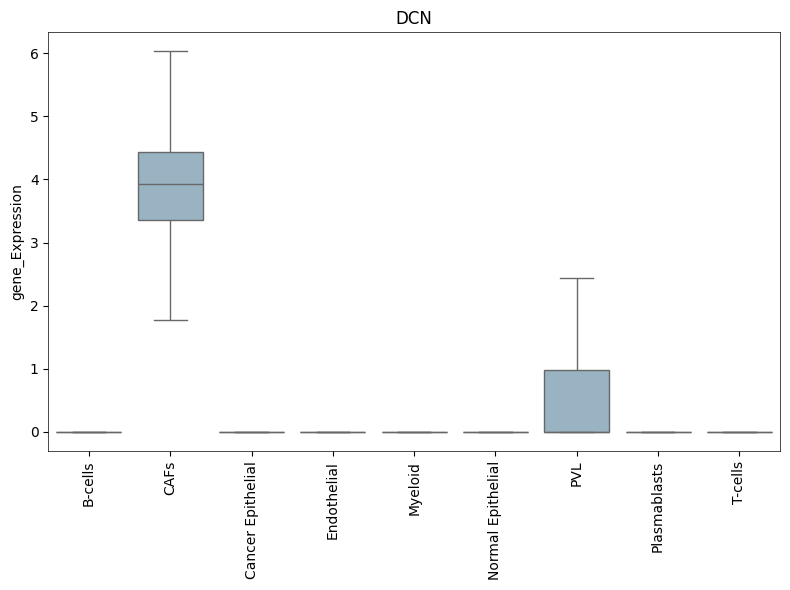

In [13]:
dc.visualize.declust_marker_boxplot(sc_adata, sc_marker_gene, 'DCN')

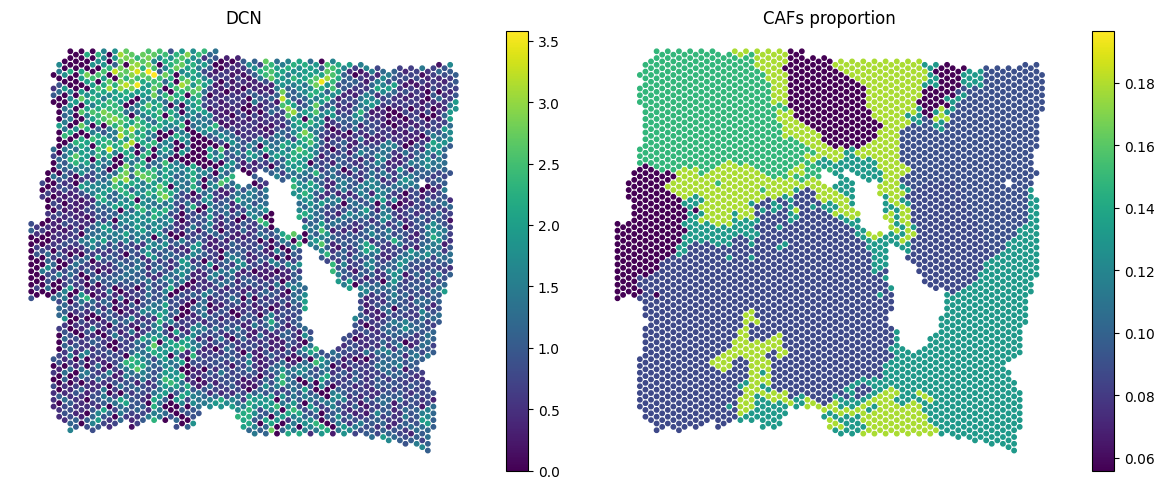

In [14]:
dc.visualize.declust_results_visualize(
    st_adata, sc_marker_gene, DECLUST_df, coords,
    gene_name='DCN', cell_type='CAFs'
)

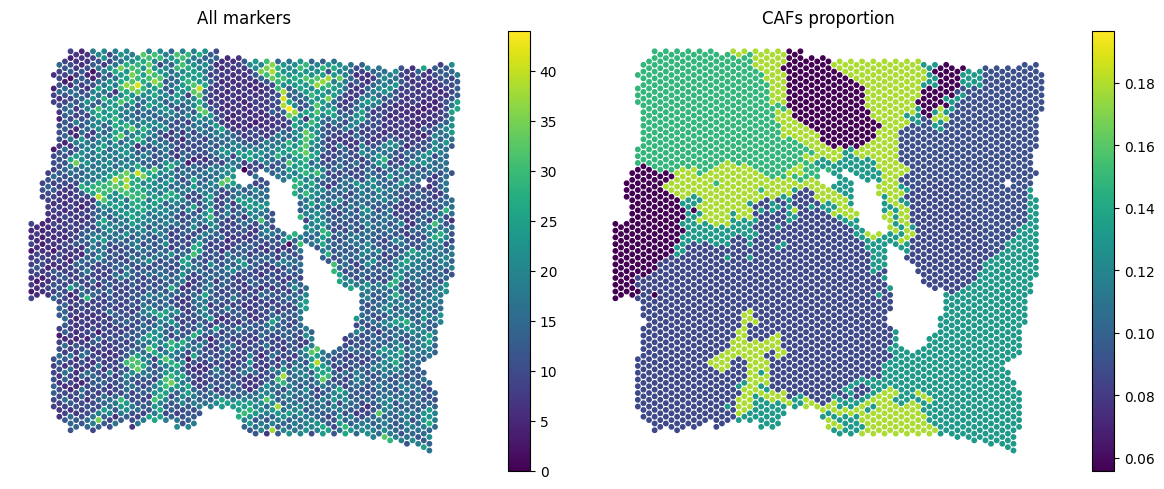

In [15]:
dc.visualize.declust_results_visualize(
    st_adata, sc_marker_gene, DECLUST_df, coords,
    cell_type='CAFs', agg_method='sum'
)

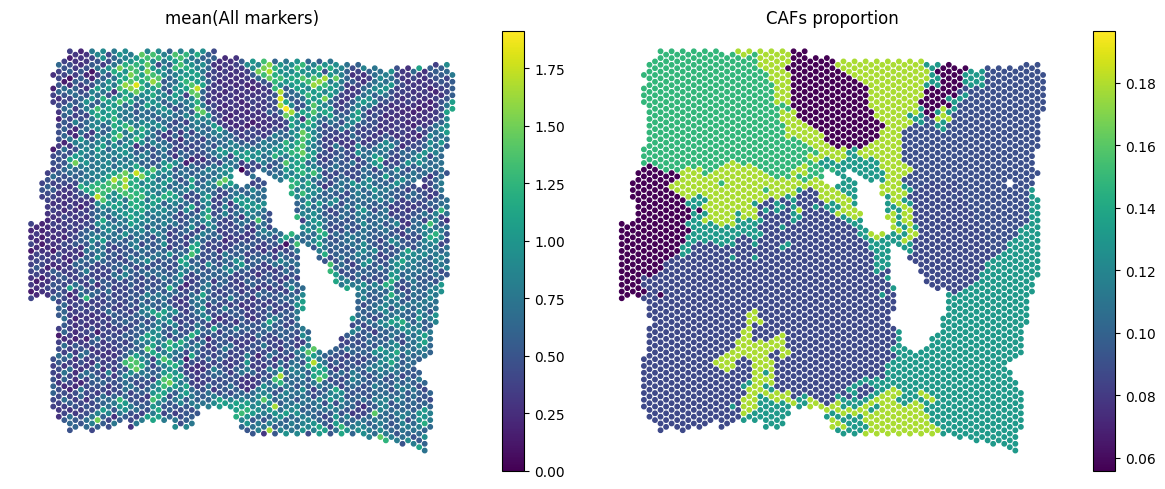

In [16]:
dc.visualize.declust_results_visualize(
    st_adata, sc_marker_gene, DECLUST_df, coords,
    cell_type='CAFs', agg_method='mean'
)